### 5.1 PCA

In [1]:
import pandas as pd
df_wine = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

In [2]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std  = sc.transform(X_test)

C:\Users\yueki\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# 5.1.2 Caculate eigenvalue & eigenvector
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('/nEigenvalues \n%s' % eigen_vals)

/nEigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [4]:
%matplotlib inline

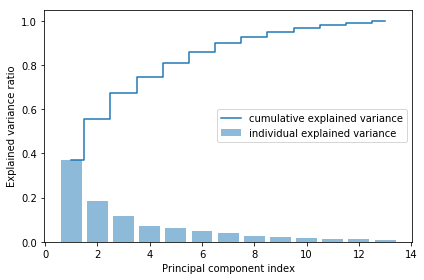

In [5]:
# 5.1.3
tot = sum(eigen_vals)
var_exp = [( i / tot) for i in sorted(eigen_vals, reverse=True)]

cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt

plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
       label='individual explained variance')

plt.step(range(1,14),cum_var_exp, where='mid',
        label='cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [6]:
#$ 5.1.4 Feature transformation

eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i])
                for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W::\n',w)


Matrix W::
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

In [8]:
X_train_pca = X_train_std.dot(w)

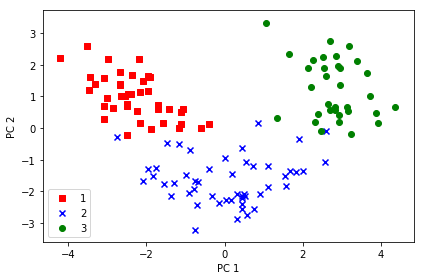

In [9]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0],
                X_train_pca[y_train==l, 1],
               c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()
    

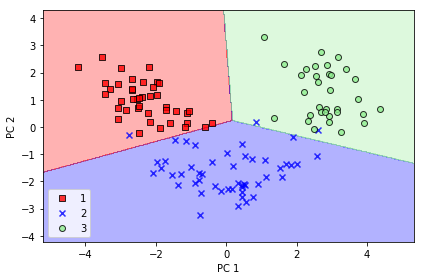

In [10]:
# 5.1.5 Principal component analysis in scikit-learn

# import method defined in chap2
from _tools import plot_decision_regions

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

lr = LogisticRegression()

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

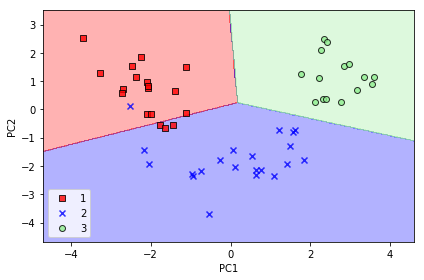

In [11]:
plot_decision_regions(X_test_pca, y_test,classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [12]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)

pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### 5.2 LDA

#### 5.2.3 Calculate scatter matrix

In [13]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('MV %s: %s\n' %(label,mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [14]:
d = 13 # character num
S_W = np.zeros((d, d))
for label,mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
        S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))     

Within-class scatter matrix: 13x13


In [15]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec  in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [16]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
              for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

0.4190441115034062
0.19673290564476184
6.490794717846114e-17
3.170566999301108e-17
3.170566999301108e-17
3.0247612577021183e-17
2.4210247294590214e-17
2.4210247294590214e-17
2.0796794809052003e-17
1.507520868083642e-17
6.560589268345932e-18
6.560589268345932e-18
0.0


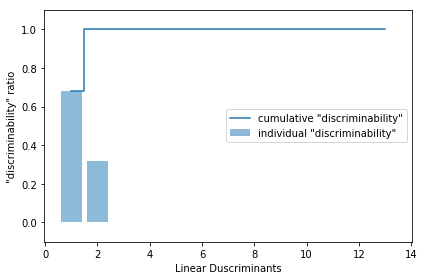

In [18]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14), discr, alpha=0.5, align='center',
       label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
        label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Duscriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [22]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))

print('Matrix W:\n', w)

Matrix W:
 [[-0.1497 -0.3246]
 [ 0.064  -0.1482]
 [ 0.0169 -0.3136]
 [ 0.1269  0.2537]
 [-0.0495 -0.0227]
 [ 0.2168 -0.1613]
 [-0.7542  0.4865]
 [-0.1321  0.0371]
 [ 0.0507  0.0127]
 [ 0.3038 -0.3411]
 [-0.0009  0.1639]
 [-0.2212  0.0953]
 [-0.4214 -0.5413]]


#### 5.2.5

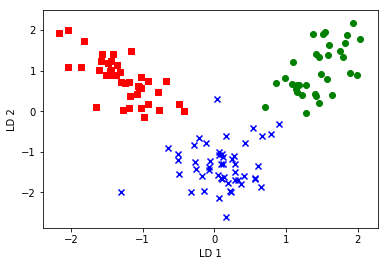

In [24]:
X_train_lda = X_train_std.dot(w)
colors= ['r''','b','g']
markers = ['s','x','o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### 5.2.6 LDA in scikit-learn


In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

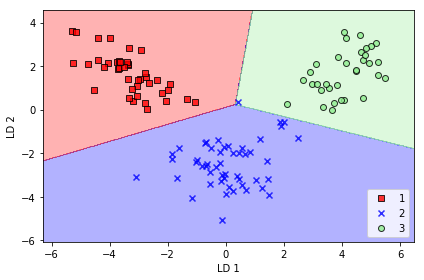

In [30]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


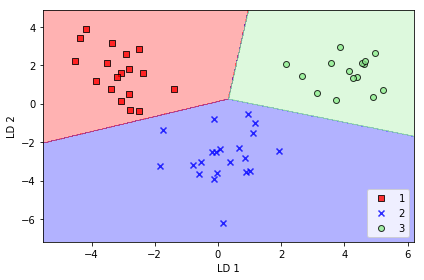

In [33]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel(('LD 1'))
plt.ylabel(('LD 2'))
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


array([[ 8.9444e-01, -3.8812e-01,  1.1007e+00, -8.1202e-01,  1.1320e+00,
         1.0981e+00,  7.1204e-01,  1.8101e-01,  6.6280e-02,  5.1286e-01,
         7.9630e-01,  4.4830e-01,  1.9059e+00],
       [-1.0488e+00, -7.7299e-01,  5.4119e-01, -2.4094e-01,  3.4941e-01,
        -7.0722e-01, -3.0812e-01,  6.7614e-01, -1.0352e+00, -9.0657e-01,
         2.2457e+00, -5.6188e-01, -1.2287e+00],
       [ 1.6474e+00, -4.1378e-01,  2.4277e-01, -1.5634e+00, -2.1975e-01,
         2.8488e-01,  4.4719e-01, -5.6167e-01,  5.7466e-01,  6.7964e-02,
         2.9806e-01,  1.3863e+00,  1.6447e+00],
       [ 2.0216e-01, -4.9075e-01, -9.1362e-01, -2.5854e+00,  6.4834e-02,
         5.2884e-01,  6.8261e-01, -8.9176e-01, -6.1156e-01, -3.0066e-01,
         4.3395e-01,  1.1266e+00,  9.0714e-01],
       [-8.0589e-01, -1.0980e+00, -1.0628e+00, -3.9122e-01, -7.8891e-01,
         1.9438e+00,  1.6537e+00, -1.0568e+00,  5.2382e-01, -2.4982e-01,
         3.8865e-01,  2.1740e-01, -2.9141e-01],
       [-7.0873e-01,  5.7835e-